In [4]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter

In [12]:
# yes this needs to be fixed
who_data = pd.read_csv('cholera_data.csv')

In [13]:
def SIR_model(y, t, alpha, beta):
#The rate of re-infection is set to 0, 
#as cholera is reported to confer longterm immunity after infection:
#"cholerae infection resulted in 100% protection against reinfection 
#with either the homologous or heterologous serotype for at least 
#3 years—the longest interval tested" - Jason B Harris, Cholera: Immunity and Prospects in Vaccine Development
#https://academic.oup.com/jid/article/218/suppl_3/S141/5089248
    
    S, I, R = y
    dSdt = -beta*S*I
    dIdt = beta*S*I - alpha*I 
    dRdt = alpha*I
    
    return dSdt, dIdt, dRdt

In [14]:
N = 44970000 #South African population in 2000, according to https://data.worldbank.org/indicator/SP.POP.TOTL?locations=ZA
I0 = who_data.iloc[0, 0] / N
S0 = (N - who_data.iloc[0,0])  / N
#R0 = 22 / N

# We are given the initial number of dead people, 22
# Assuming that 1% of cases result in death, this gives us an initial removed number of 22*100
R0 = 22*100/N

alpha = 0.0054
beta = 0.029304

t = np.linspace(0, 200, 200)

We may need to make R0 higher, if we want to account for recoveries as well.

In [15]:
sol = np.array(odeint(SIR_model, [S0, I0, R0], who_data.iloc[:,2], args=(alpha, beta)))

Some assumptions I made for figuring out the total number of recovered. 10-20% of infected individuals have severe symptoms (this is given). Let's use 10%. And suppose that 10% of those with severe symptoms die.

So 1% of cases result in death (I chose the numbers just to get the 1%). So in our "truth" data for the removed population, I add in the estimated recovered population, which is estimated to be 99 times the dead population. The R0 for the model is modified to have recovered people as well.

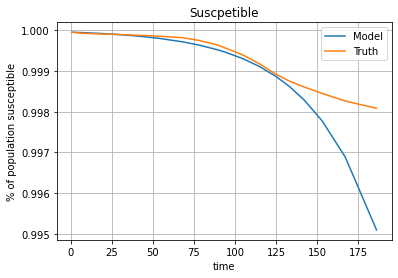

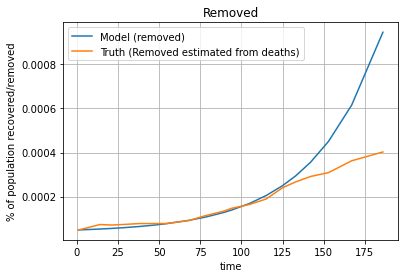

In [16]:
plt.figure(figsize = [6, 4])
times = who_data.iloc[:,2]
plt.plot(times, sol[:, 0], label = "Model")

susceptibles = (who_data.iloc[:, 0]*(-1) + N)

plt.plot(times, susceptibles / N, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.show()

plt.figure(figsize = [6, 4])
plt.plot(times, sol[:, 2], label = "Model (removed)")

plt.plot(times, (who_data.iloc[:, 1]*100) / N, label = "Truth (Removed estimated from deaths)") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population recovered/removed")
plt.title("Removed")
plt.show()

NOTE: Since the data given are only reporting deaths, and the model is accounting for both deaths and recoveries, we should expect the the model to report higher value

The first plot shows us that at around t=125, some control measure is put in place (maybe).

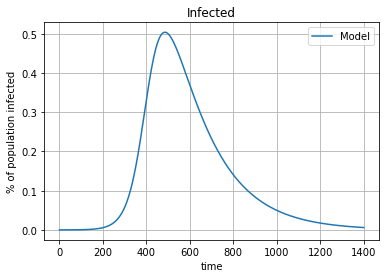

In [17]:
t2 = np.linspace(0,1400,1400)
sol = np.array(odeint(SIR_model, [S0, I0, R0], t2, args=(alpha, beta)))

plt.figure(figsize = [6, 4])
plt.plot(t2, sol[:, 1], label = "Model")
# not correct
# infected = N - who_data.iloc[:,0] + who_data.iloc[:,1]

# plt.plot(times,infected/N, label = "true infected")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population infected")
plt.title("Infected")
plt.show()

The infected plot is basically a prediction with no controls

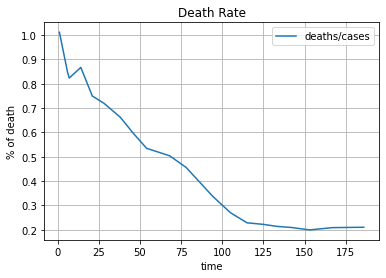

In [18]:
rate = who_data.iloc[:, 1]/who_data.iloc[:, 0]

plt.figure(figsize = [6, 4])
plt.plot(times, 100*rate, label = "deaths/cases")

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of death")
plt.title("Death Rate")
plt.show()

This shows the deaths/cases as t increases. It's likely not too meaningful... but is levels off to be around 0.2% of the population

In [19]:
# Get the number of infected:

infected = N - who_data.iloc[:,0] -  who_data.iloc[:,1]

In [20]:
# code borrowed from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b


alpha = 0.005
beta = 0.002
initial_conditions = [S0, I0, R0]

num_days = 16
tspan = times[0:num_days]
days = len(tspan)
data = np.concatenate((np.array(susceptibles[0:num_days]/N), np.array(who_data.iloc[0:num_days, 1]*100.0/N)))

def error(params, initial_conditions, tspan, data):
    alpha, beta = params['alpha'].value, params['beta'].value
    sol = np.array(odeint(SIR_model, [S0, I0, R0], tspan, args=(alpha, beta)))
    
    sol_1d = np.concatenate((np.array(sol[:, 0]), np.array(sol[:,2])))
    return sol_1d - data

params = Parameters()
params.add('beta', value=beta, min=0, max=10)
params.add('alpha', value=alpha, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

We really only need to fit the S(t) and I(t) curves to the data. So, we are doing nonlinear lms for a system of two equations.

In [21]:
result.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha   0.00523        0       10 0.0007302     True     None     None
beta    0.02818        0       10 0.0005173     True     None     None


There is clearly a mistake in the code somewhere.

Let's check how the solution looks, with these parameters.

In [22]:
# yes it's hardcoded, sorry :(
beta = 0.02818 
alpha =0.00523

sol = np.array(odeint(SIR_model, [S0, I0, R0], times, args=(alpha, beta)))

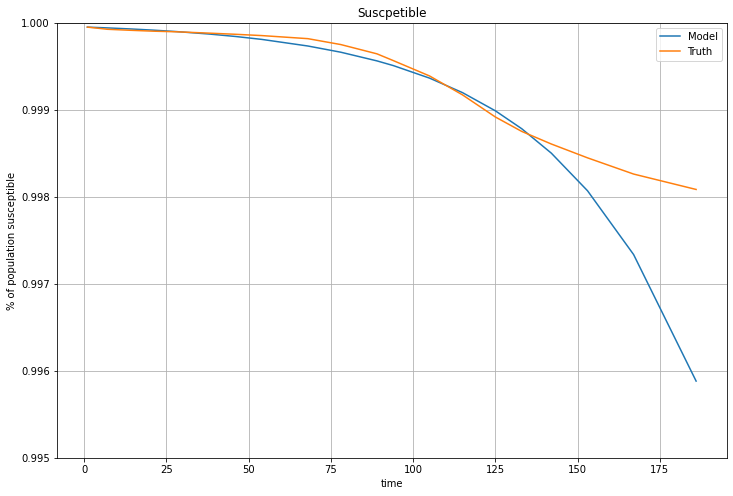

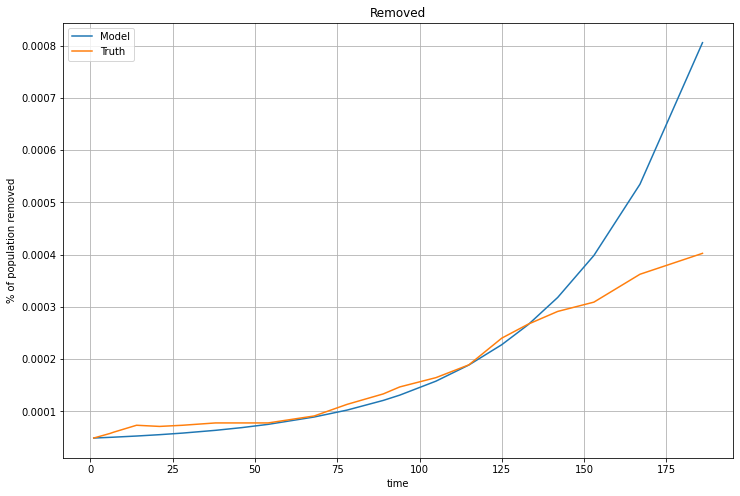

In [23]:
p = plt.figure(figsize = [12, 8])
plt.plot(times, sol[:, 0], label = "Model")

times = who_data.iloc[:,2]

susceptibles = (who_data.iloc[:, 0]*(-1) + N)

plt.plot(times, susceptibles / N, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")

plt.ylim(0.995,1)
plt.show()

# Plot removed
p = plt.figure(figsize = [12, 8])
plt.plot(times, sol[:, 2], label = "Model")

times = who_data.iloc[:,2]

rem = (who_data.iloc[:, 1])*100

plt.plot(times, rem / N, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population removed")
plt.title("Removed")

#plt.ylim(0.995,1)
plt.show()

Here is the model after using least squares to find the optimal parmaters alpha and beta.
Since this data for the removed population is not very accurate, we may want to put less weight on this in the optimization
